In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns
stop_words = set(stopwords.words("english"))
from collections import Counter
from nltk.stem import PorterStemmer, LancasterStemmer

In [2]:
df = pd.read_csv (r'E:\IMDBDataset.csv')
df.shape

'''
import os
for dirname, _, filenames in os.walk('IMDP'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
df = pd.read_csv (os.path.join(dirname, filename))
df.shape
'''

"\nimport os\nfor dirname, _, filenames in os.walk('IMDP'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\ndf = pd.read_csv (os.path.join(dirname, filename))\ndf.shape\n"

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.sentiment.replace("negative", 0, inplace=True)
df.sentiment.replace("positive", 1, inplace=True)

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


Text(0.5, 1.0, 'Sentiment distribution')

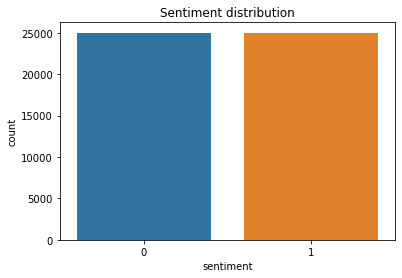

In [7]:
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment distribution")

In [8]:
duplicated_count = df.duplicated().sum()
print("Number of duplicate entries: ", duplicated_count)

Number of duplicate entries:  418


In [9]:
df = df.drop_duplicates('review')

In [10]:
def text_processing(x):
     x = x.lower()
     x = re.sub('<br />','', x)
     x = re.sub(r"https\S+|www\S+|http\S+", '', x, flags = re.MULTILINE)
     x = re.sub(r'\@w+|\#', '', x)
     x = re.sub(r'[^\w\s]','',x)
     x_tokens = word_tokenize(x)
     x_filtered = [i for i in x_tokens if not i in stop_words]
     return x_filtered


In [11]:

df.review  = df['review'].apply(lambda x: text_processing(x))
df.review.head()

0    [one, reviewers, mentioned, watching, 1, oz, e...
1    [wonderful, little, production, filming, techn...
2    [thought, wonderful, way, spend, time, hot, su...
3    [basically, theres, family, little, boy, jake,...
4    [petter, matteis, love, time, money, visually,...
Name: review, dtype: object

In [12]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return' '.join(text)


In [13]:
df.review = df['review'].apply(lambda x: stemming(x))
df.review.head()

0    one review mention watch 1 oz episod youll hoo...
1    wonder littl product film techniqu unassum old...
2    thought wonder way spend time hot summer weeke...
3    basic there famili littl boy jake think there ...
4    petter mattei love time money visual stun film...
Name: review, dtype: object

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(ngram_range=(1, 2), max_features=200)
x = vec.fit_transform(df['review'])
count_tokens=vec.get_feature_names_out()
# tf_idf_DF=pd.DataFrame(data=x.tocsr())

In [15]:
x.toarray().shape

(49582, 200)

In [16]:
y = df['sentiment']
y.to_numpy()


array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [48]:
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,  # Set size of test_set
    # random_state=456,  # Random seed for reproducibility
)
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((39665, 200), (9917, 200), (39665,), (9917,))

In [45]:
DT=DecisionTreeClassifier(criterion='entropy').fit(X_train,y_train)
DT_pred = DT.predict(X_test)
print("Accuracy on the test set: ", accuracy_score(y_test, DT_pred)*100 ,"%")

Accuracy on the test set:  66.72380760310578 %


In [46]:
cross_val_score(DT, X_train.reshape((39665, -1)), y_train, cv=7)

array([0.65325569, 0.6611964 , 0.66984295, 0.66396047, 0.66166608,
       0.66501941, 0.67066714])

Accuracy on the test set:  66.72380760310578 % 

[[0.33094686 0.16628013]
 [0.1664818  0.33629122]] 

              precision    recall  f1-score   support

           0       0.67      0.67      0.67      4931
           1       0.67      0.67      0.67      4986

    accuracy                           0.67      9917
   macro avg       0.67      0.67      0.67      9917
weighted avg       0.67      0.67      0.67      9917



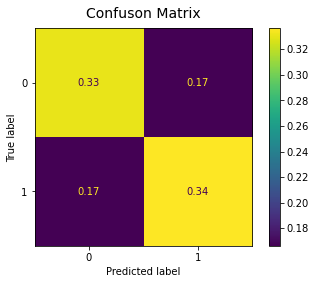

In [47]:
print("Accuracy on the test set: ", accuracy_score(y_test, DT_pred)*100,"%","\n")
print(confusion_matrix(y_test, DT_pred)/ len(y_test),"\n")
print(classification_report(y_test, DT_pred))

ConfusionMatrixDisplay.from_estimator(DT, X_test, y_test, normalize='all')
plt.title("Confuson Matrix", y=1.02, size=14)
plt.show()

In [29]:
log_reg = LogisticRegression().fit(X_train, y_train)
y_predicted = log_reg.predict(X_test)
print("Accuracy on the test set: ", accuracy_score(y_test, y_predicted)*100 ,"%")

Accuracy on the test set:  78.81415750731068 %


In [30]:
cross_val_score(log_reg, X_train.reshape((39665, -1)), y_train, cv=7)

array([0.79883536, 0.78665961, 0.78471855, 0.78203318, 0.77532651,
       0.78220967, 0.78662196])

Accuracy on the test set:  78.81415750731068 % 

[[0.38691136 0.11001311]
 [0.10184532 0.40123021]] 

              precision    recall  f1-score   support

           0       0.79      0.78      0.79      4928
           1       0.78      0.80      0.79      4989

    accuracy                           0.79      9917
   macro avg       0.79      0.79      0.79      9917
weighted avg       0.79      0.79      0.79      9917



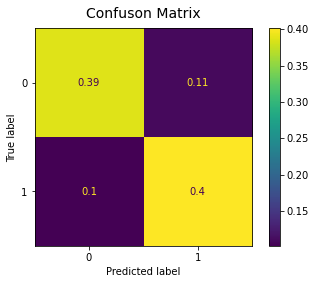

In [32]:
print("Accuracy on the test set: ", accuracy_score(y_test, y_predicted)*100,"%","\n")
print(confusion_matrix(y_test, y_predicted) / len(y_test),"\n")
print(classification_report(y_test, y_predicted))

ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test, normalize='all')
plt.title("Confuson Matrix", y=1.02, size=14)
plt.show()


In [41]:
mnnb = MultinomialNB().fit(X_train, y_train)
mnb_pred = mnnb.predict(X_test)
print("Accuracy on the test set: ", accuracy_score(y_test, y_predicted)*100 ,"%")

Accuracy on the test set:  77.38227286477766 %


In [42]:
cross_val_score(mnnb, X_train.reshape((39665, -1)), y_train, cv=7)

array([0.76901359, 0.76389624, 0.77554262, 0.76897282, 0.76420755,
       0.77320861, 0.77197317])

Accuracy on the test set:  77.38227286477766 % 

[[0.37944943 0.11152566]
 [0.11465161 0.3943733 ]] 

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      4869
           1       0.78      0.77      0.78      5048

    accuracy                           0.77      9917
   macro avg       0.77      0.77      0.77      9917
weighted avg       0.77      0.77      0.77      9917



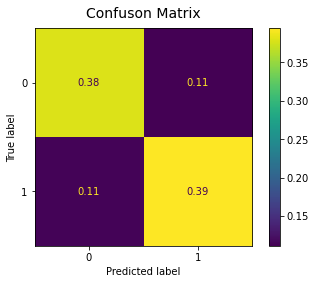

In [43]:
print("Accuracy on the test set: ", accuracy_score(y_test, mnb_pred)*100,"%","\n")
print(confusion_matrix(y_test, mnb_pred)/ len(y_test),"\n")
print(classification_report(y_test, mnb_pred))

ConfusionMatrixDisplay.from_estimator(mnnb, X_test, y_test, normalize='all')
plt.title("Confuson Matrix", y=1.02, size=14)
plt.show()

In [49]:
svvc = LinearSVC().fit(X_train, y_train)
svvc_pred = svvc.predict(X_test)
print("Accuracy on the test set: ", accuracy_score(y_test, svvc_pred)*100 ,"%")

Accuracy on the test set:  78.6225673086619 %


In [50]:
cross_val_score(svvc, X_train.reshape((39665, -1)), y_train, cv=7)

array([0.78277748, 0.77766014, 0.78665961, 0.78838687, 0.7897988 ,
       0.77620897, 0.78821038])

Accuracy on the test set:  78.6225673086619 % 

[[0.38872643 0.11384491]
 [0.09992941 0.39749924]] 

              precision    recall  f1-score   support

           0       0.80      0.77      0.78      4984
           1       0.78      0.80      0.79      4933

    accuracy                           0.79      9917
   macro avg       0.79      0.79      0.79      9917
weighted avg       0.79      0.79      0.79      9917



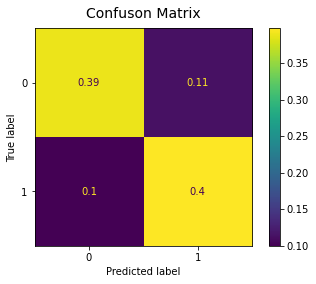

In [51]:
print("Accuracy on the test set: ", accuracy_score(y_test, svvc_pred)*100,"%","\n")
print(confusion_matrix(y_test, svvc_pred)/ len(y_test),"\n")
print(classification_report(y_test, svvc_pred))

ConfusionMatrixDisplay.from_estimator(svvc, X_test, y_test, normalize='all')
plt.title("Confuson Matrix", y=1.02, size=14)
plt.show()